In [1]:
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import *

In [2]:
base_dir = r'C:\Users\khuma\pneumonia-xray-images\chest_xray'


print('Contents of base directory:')
print(os.listdir(base_dir))

print('\nContents of train directory:')
print(os.listdir(f'{base_dir}/train'))

print('\nContents of val directory:')
print(os.listdir(f'{base_dir}/val'))

print('\nContents of test directory:')
print(os.listdir(f'{base_dir}/test'))

Contents of base directory:
['chest_xray', 'test', 'train', 'val', '__MACOSX']

Contents of train directory:
['NORMAL', 'PNEUMONIA']

Contents of val directory:
['NORMAL', 'PNEUMONIA']

Contents of test directory:
['NORMAL', 'PNEUMONIA']


In [5]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

#Directory with training NORMAL/PNEUMONIA pictures
train_NORMAL_dir = os.path.join(train_dir, 'NORMAL')
train_PNEUMONIA_dir = os.path.join(train_dir, 'PNEUMONIA')

#Directory with validation NORMAL/PNEUMONIA pictures
val_NORMAL_dir = os.path.join(val_dir, 'NORMAL')
val_PNEUMONIA_dir = os.path.join(val_dir, 'PNEUMONIA')

#Directory with test NORMAL/PNEUMONIA pictures
test_NORMAL_dir = os.path.join(test_dir, 'NORMAL')
test_PNEUMONIA_dir = os.path.join(test_dir, 'PNEUMONIA')

In [6]:
train_NORMAL_fnames = os.listdir(train_NORMAL_dir)
train_PNEUMONIA_fnames = os.listdir(train_PNEUMONIA_dir)

print(train_NORMAL_fnames[:5])
print(train_PNEUMONIA_fnames[:5])

['IM-0115-0001.jpeg', 'IM-0117-0001.jpeg', 'IM-0119-0001.jpeg', 'IM-0122-0001.jpeg', 'IM-0125-0001.jpeg']
['person1000_bacteria_2931.jpeg', 'person1000_virus_1681.jpeg', 'person1001_bacteria_2932.jpeg', 'person1002_bacteria_2933.jpeg', 'person1003_bacteria_2934.jpeg']


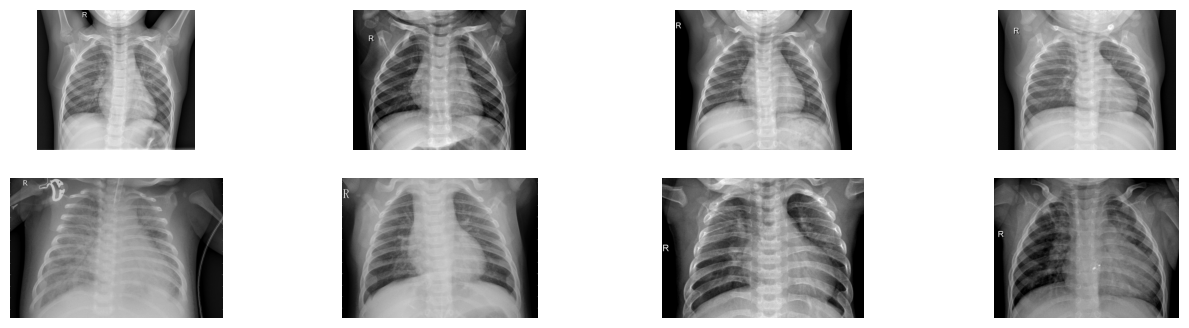

In [7]:
nrows = 2
ncols = 4

pic_index = 0 #Index for iterating over images

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*2)

pic_index+=4

next_NORMAL_pix = [os.path.join(train_NORMAL_dir, fname) 
                for fname in train_NORMAL_fnames[pic_index-4:pic_index]]

next_PNEUMONIA_pix = [os.path.join(train_PNEUMONIA_dir, fname) 
                for fname in train_PNEUMONIA_fnames[pic_index-4:pic_index]]

for i, img_path in enumerate(next_NORMAL_pix+next_PNEUMONIA_pix):
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off')

  img = mpimg.imread(img_path)
  plt.imshow(img, cmap='gray')

plt.show();

In [8]:
print('total training NORMAL images :', len(os.listdir(train_NORMAL_dir)))
print('total training PNEUMONIA images :', len(os.listdir(train_PNEUMONIA_dir)))

print('total validation NORMAL images :', len(os.listdir(val_NORMAL_dir)))
print('total validation PNEUMONIA images :', len(os.listdir(val_PNEUMONIA_dir)))

print('total test NORMAL images :', len(os.listdir(test_NORMAL_dir)))
print('total test PNEUMONIA images :', len(os.listdir(test_PNEUMONIA_dir)))

total training NORMAL images : 1341
total training PNEUMONIA images : 3875
total validation NORMAL images : 8
total validation PNEUMONIA images : 8
total test NORMAL images : 234
total test PNEUMONIA images : 390


C:\Users\khuma\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


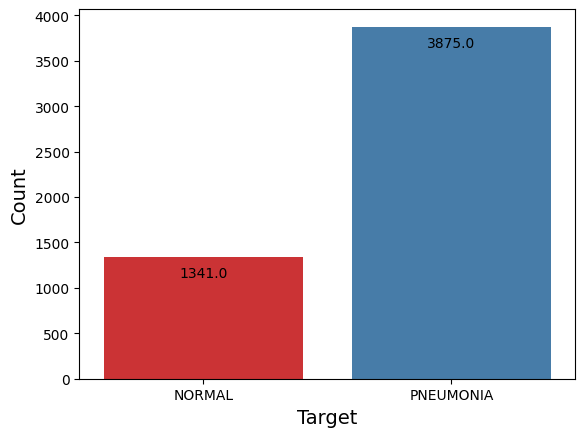

In [9]:
ax = sns.barplot(x = ['NORMAL', 'PNEUMONIA'], y = [len(os.listdir(train_NORMAL_dir)), len(os.listdir(train_PNEUMONIA_dir))]
            , palette = 'Set1')
for p in ax.patches:
    ax.annotate(format(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, -12), 
                   textcoords = 'offset points')
plt.xlabel('Target', size=14)
plt.ylabel('Count', size=14);

In [10]:
train_datagen = ImageDataGenerator(rescale = 1.0/255., 
                                   featurewise_center=False,  # set input mean to 0 over the dataset
                                   samplewise_center=False,  # set each sample mean to 0
                                   featurewise_std_normalization=False,  # divide inputs by std of the dataset
                                   samplewise_std_normalization=False,  # divide each input by its std
                                   zca_whitening=False,  # apply ZCA whitening
                                   rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
                                   zoom_range = 0.2, # Randomly zoom image 
                                   width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                                   height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                                   horizontal_flip = True,  # randomly flip images
                                   vertical_flip=False)
val_datagen = ImageDataGenerator(rescale = 1.0/255.)
test_datagen  = ImageDataGenerator(rescale = 1.0/255.)

# --------------------
#Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 128,
                                                    class_mode = 'binary',
                                                    target_size = (299, 299),
                                                    color_mode='grayscale')     
# --------------------
#Flow validation images in batches of 20 using val_datagen generator
# --------------------
val_generator =  val_datagen.flow_from_directory(val_dir,
                                                 batch_size = 8,
                                                 class_mode = 'binary',
                                                 target_size = (299, 299),
                                                 color_mode='grayscale')
# --------------------
#Flow test images in batches of 20 using test_datagen generator
# --------------------
test_generator =  test_datagen.flow_from_directory(test_dir,
                                                   batch_size = 64,
                                                   class_mode = 'binary',
                                                   target_size = (299, 299),
                                                   color_mode='grayscale')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(299, 299, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 297, 297, 16)      160       
                                                                 
 batch_normalization (Batch  (None, 297, 297, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 148, 148, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 32)        0         
 g2D)                                                            
                                                        

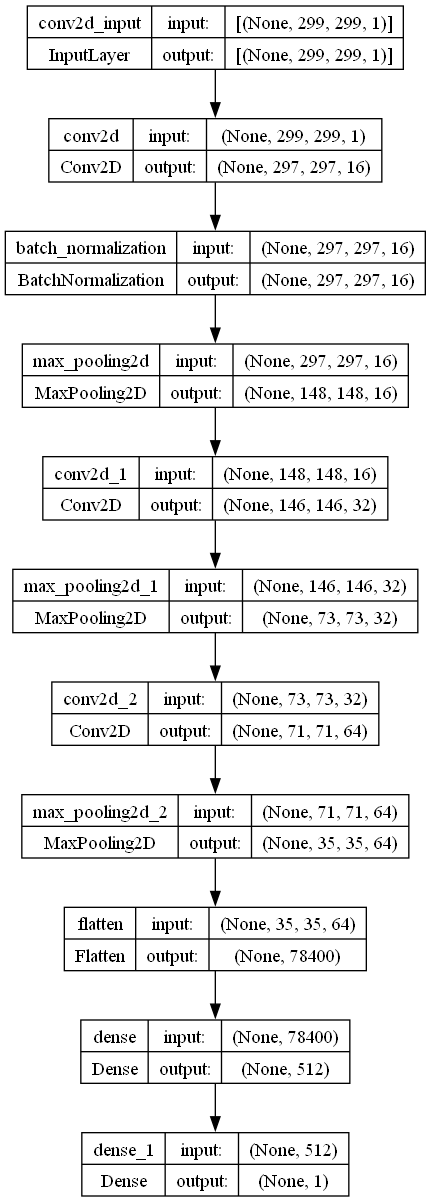

In [13]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [14]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precision1 = precision(y_true, y_pred)
    recall1 = recall(y_true, y_pred)
    return 2*((precision1*recall1)/(precision1+recall1+K.epsilon()))

In [15]:
from tensorflow.keras import backend as K

In [16]:
import tensorflow as tf
early_stopping=tf.keras.callbacks. EarlyStopping (
monitor="val_loss",
min_delta=0.01,
patience=5,
verbose=0,
mode="auto",
baseline=None,
restore_best_weights=False,
)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy', f1, precision, recall])

# Fit the model with early stopping
history = model.fit(train_generator,
                    epochs=8,
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/8


41/41 [==============================] - 336s 8s/step - loss: 61.7138 - accuracy: 0.7322 - f1: 0.7861 - precision: 0.7725 - recall: 0.8593
Epoch 2/8
41/41 [==============================] - 271s 7s/step - loss: 0.6720 - accuracy: 0.7118 - f1: 0.7970 - precision: 0.7787 - recall: 0.9001
Epoch 3/8
41/41 [==============================] - 266s 6s/step - loss: 1.4800 - accuracy: 0.7049 - f1: 0.8018 - precision: 0.7709 - recall: 0.9054
Epoch 4/8
41/41 [==============================] - 245s 6s/step - loss: 0.5771 - accuracy: 0.7358 - f1: 0.8393 - precision: 0.7508 - recall: 0.9798
Epoch 5/8
41/41 [==============================] - 248s 6s/step - loss: 0.5713 - accuracy: 0.7429 - f1: 0.8518 - precision: 0.7426 - recall: 1.0000
Epoch 6/8
41/41 [==============================] - 234s 6s/step - loss: 0.5709 - accuracy: 0.7429 - f1: 0.8521 - precision: 0.7428 - recall: 1.0000
Epoch 7/8
41/41 [==============================] - 237s 6s/step - loss: 0.5717 - accuracy: 0.7429 - f1: 0.851

In [17]:
model.evaluate(test_generator)

10/10 [==============================] - 13s 911ms/step - loss: 0.7004 - accuracy: 0.6250 - f1: 0.7691 - precision: 0.6255 - recall: 1.0000


[0.7004125714302063, 0.625, 0.7690817713737488, 0.6255208253860474, 1.0]

Recall is an important metric especially in healthcare data. Recall literally is how many of the true positives were found, i.e. how many of the correct hits were also found.



In other words, the recall is the measure of our model correctly identifying True Positives. Thus, for all the patients who actually have Pneumonia, recall tells us how many we correctly identified as having a Pneumonia, so recall is very important in this case. What if a patient has Pneumonia, but there is no treatment given to him/her because our model predicted so? That is a situation we would like to avoid!

In [18]:
# import pickle

# # Save the model to a file
# filename = 'model.pkl'
# with open(filename, 'wb') as file:
#     pickle.dump(model, file)


In [19]:
model.save("pneumonia_cnn_model.h5")

C:\Users\khuma\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
